In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

np.random.seed(42)

df_meta = pd.read_csv('./data/modelling/final_dataset2.csv')

In [26]:
features_to_keep = ['NetRating', 'normalized_ranking_strength', 'conf_tourney_winpct', 'FG3Pct', 'Blk_mean',
                   'TournamentWinPct', 'TournamentGames', 'DefRating', 'AssistToTurnover', 'RegularSeasonWinPct', 'FGA3_mean',
                    'FTA_mean', 'FTPct', 'Possessions', 'Ast_mean', 'avg_massey_rank', 'conf_tourney_champion', 'Experience',
                   'historical_tourney_win_pct']

print(len(features_to_keep))

19


In [6]:
differential_features = []
for feature in features_to_keep:
    # Create differential column name
    diff_col = f"diff_{feature}"
    
    # Calculate the difference (TeamA - TeamB)
    df_meta[diff_col] = df_meta[f"TeamA_{feature}"] - df_meta[f"TeamB_{feature}"]
    
    # Add to our list of model features
    differential_features.append(diff_col)

print(f"\nCreated {len(differential_features)} differential features for modeling:")
for feature in differential_features:
    print(f"- {feature}")


Created 20 differential features for modeling:
- diff_NetRating
- diff_normalized_ranking_strength
- diff_conf_tourney_winpct
- diff_FG3Pct
- diff_Blk_mean
- diff_TournamentWinPct
- diff_TournamentGames
- diff_DefRating
- diff_AssistToTurnover
- diff_FTPct
- diff_RegularSeasonWinPct
- diff_FGA3_mean
- diff_FTA_mean
- diff_FTPct
- diff_Possessions
- diff_Ast_mean
- diff_avg_massey_rank
- diff_conf_tourney_champion
- diff_Experience
- diff_historical_tourney_win_pct


In [7]:
# Drop rows with any null values in our features
df_meta_clean = df_meta.dropna(subset=differential_features)

print(f"Original dataset: {len(df_meta)} rows")
print(f"After dropping nulls: {len(df_meta_clean)} rows")
print(f"Rows removed: {len(df_meta) - len(df_meta_clean)} ({(len(df_meta) - len(df_meta_clean))/len(df_meta)*100:.2f}%)")

X = df_meta_clean[differential_features]
y = df_meta_clean['TeamA_Won']


Original dataset: 1315 rows
After dropping nulls: 1284 rows
Rows removed: 31 (2.36%)


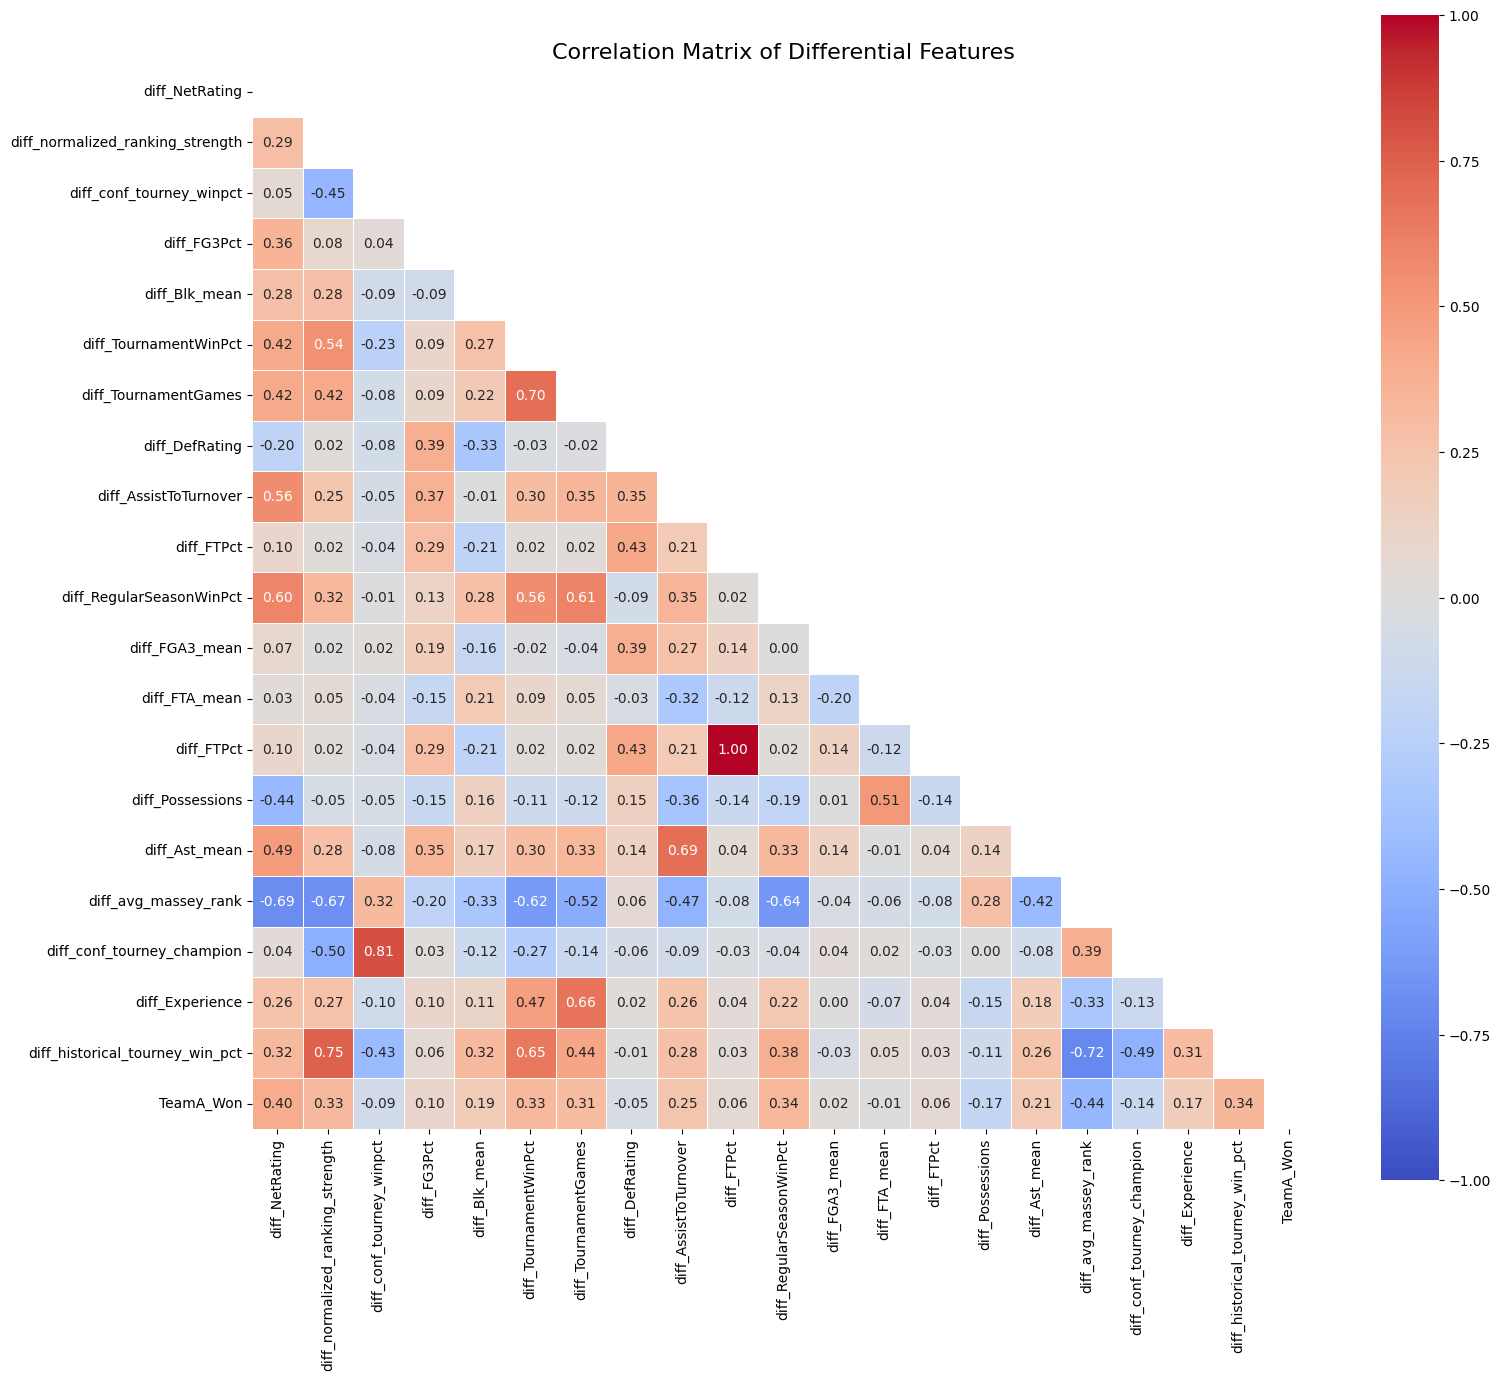


Highly correlated features (|r| > 0.75):
diff_FTPct and diff_FTPct: 1.000
diff_conf_tourney_champion and diff_conf_tourney_winpct: 0.809


In [19]:
# Make sure all features exist in your dataset
existing_cols = [col for col in differential_features if col in df_meta_clean.columns]
existing_cols.append('TeamA_Won')
if len(existing_cols) < len(differential_features):
    print(f"Warning: {len(differential_features) - len(existing_cols)} columns not found in dataset")

# Step 2: Calculate the correlation matrix
correlation_matrix = df_meta_clean[existing_cols].corr()

# Step 3: Visualize the correlation matrix with a heatmap
plt.figure(figsize=(16, 14))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Create mask for upper triangle
sns.heatmap(correlation_matrix, 
            annot=True,           # Show correlation values
            mask=mask,            # Only show lower triangle 
            cmap='coolwarm',      # Color scheme
            vmin=-1, vmax=1,      # Value range
            fmt='.2f',            # Number format
            square=True,          # Square cells
            linewidths=0.5)       # Grid line width

plt.title('Correlation Matrix of Differential Features', fontsize=16)
plt.tight_layout()
plt.show()

# Step 4: Identify highly correlated features (|r| > 0.75)
threshold = 0.75
high_corr = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr.append((correlation_matrix.columns[i], correlation_matrix.columns[j], 
                             correlation_matrix.iloc[i, j]))

# Print highly correlated feature pairs
if high_corr:
    print("\nHighly correlated features (|r| > 0.75):")
    for feat1, feat2, corr in high_corr:
        print(f"{feat1} and {feat2}: {corr:.3f}")
else:
    print("\nNo feature pairs with correlation above 0.75 found")

In [11]:
print(f'Number of Features in X: {len(list(X.columns))}')
df_meta_clean.columns

Number of Features in X: 20


Index(['Season', 'DayNum', 'TeamAID', 'TeamBID', 'TeamAScore', 'TeamBScore',
       'TeamA_Won', 'WLoc', 'NumOT', 'TeamA_TeamID',
       ...
       'diff_DefRating', 'diff_FTPct', 'diff_FGA3_mean', 'diff_FTA_mean',
       'diff_Possessions', 'diff_Ast_mean', 'diff_avg_massey_rank',
       'diff_conf_tourney_champion', 'diff_Experience',
       'diff_historical_tourney_win_pct'],
      dtype='object', length=142)

In [15]:
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


# print("\nScaled feature summary statistics:")
# print(X_scaled.describe().round(3))

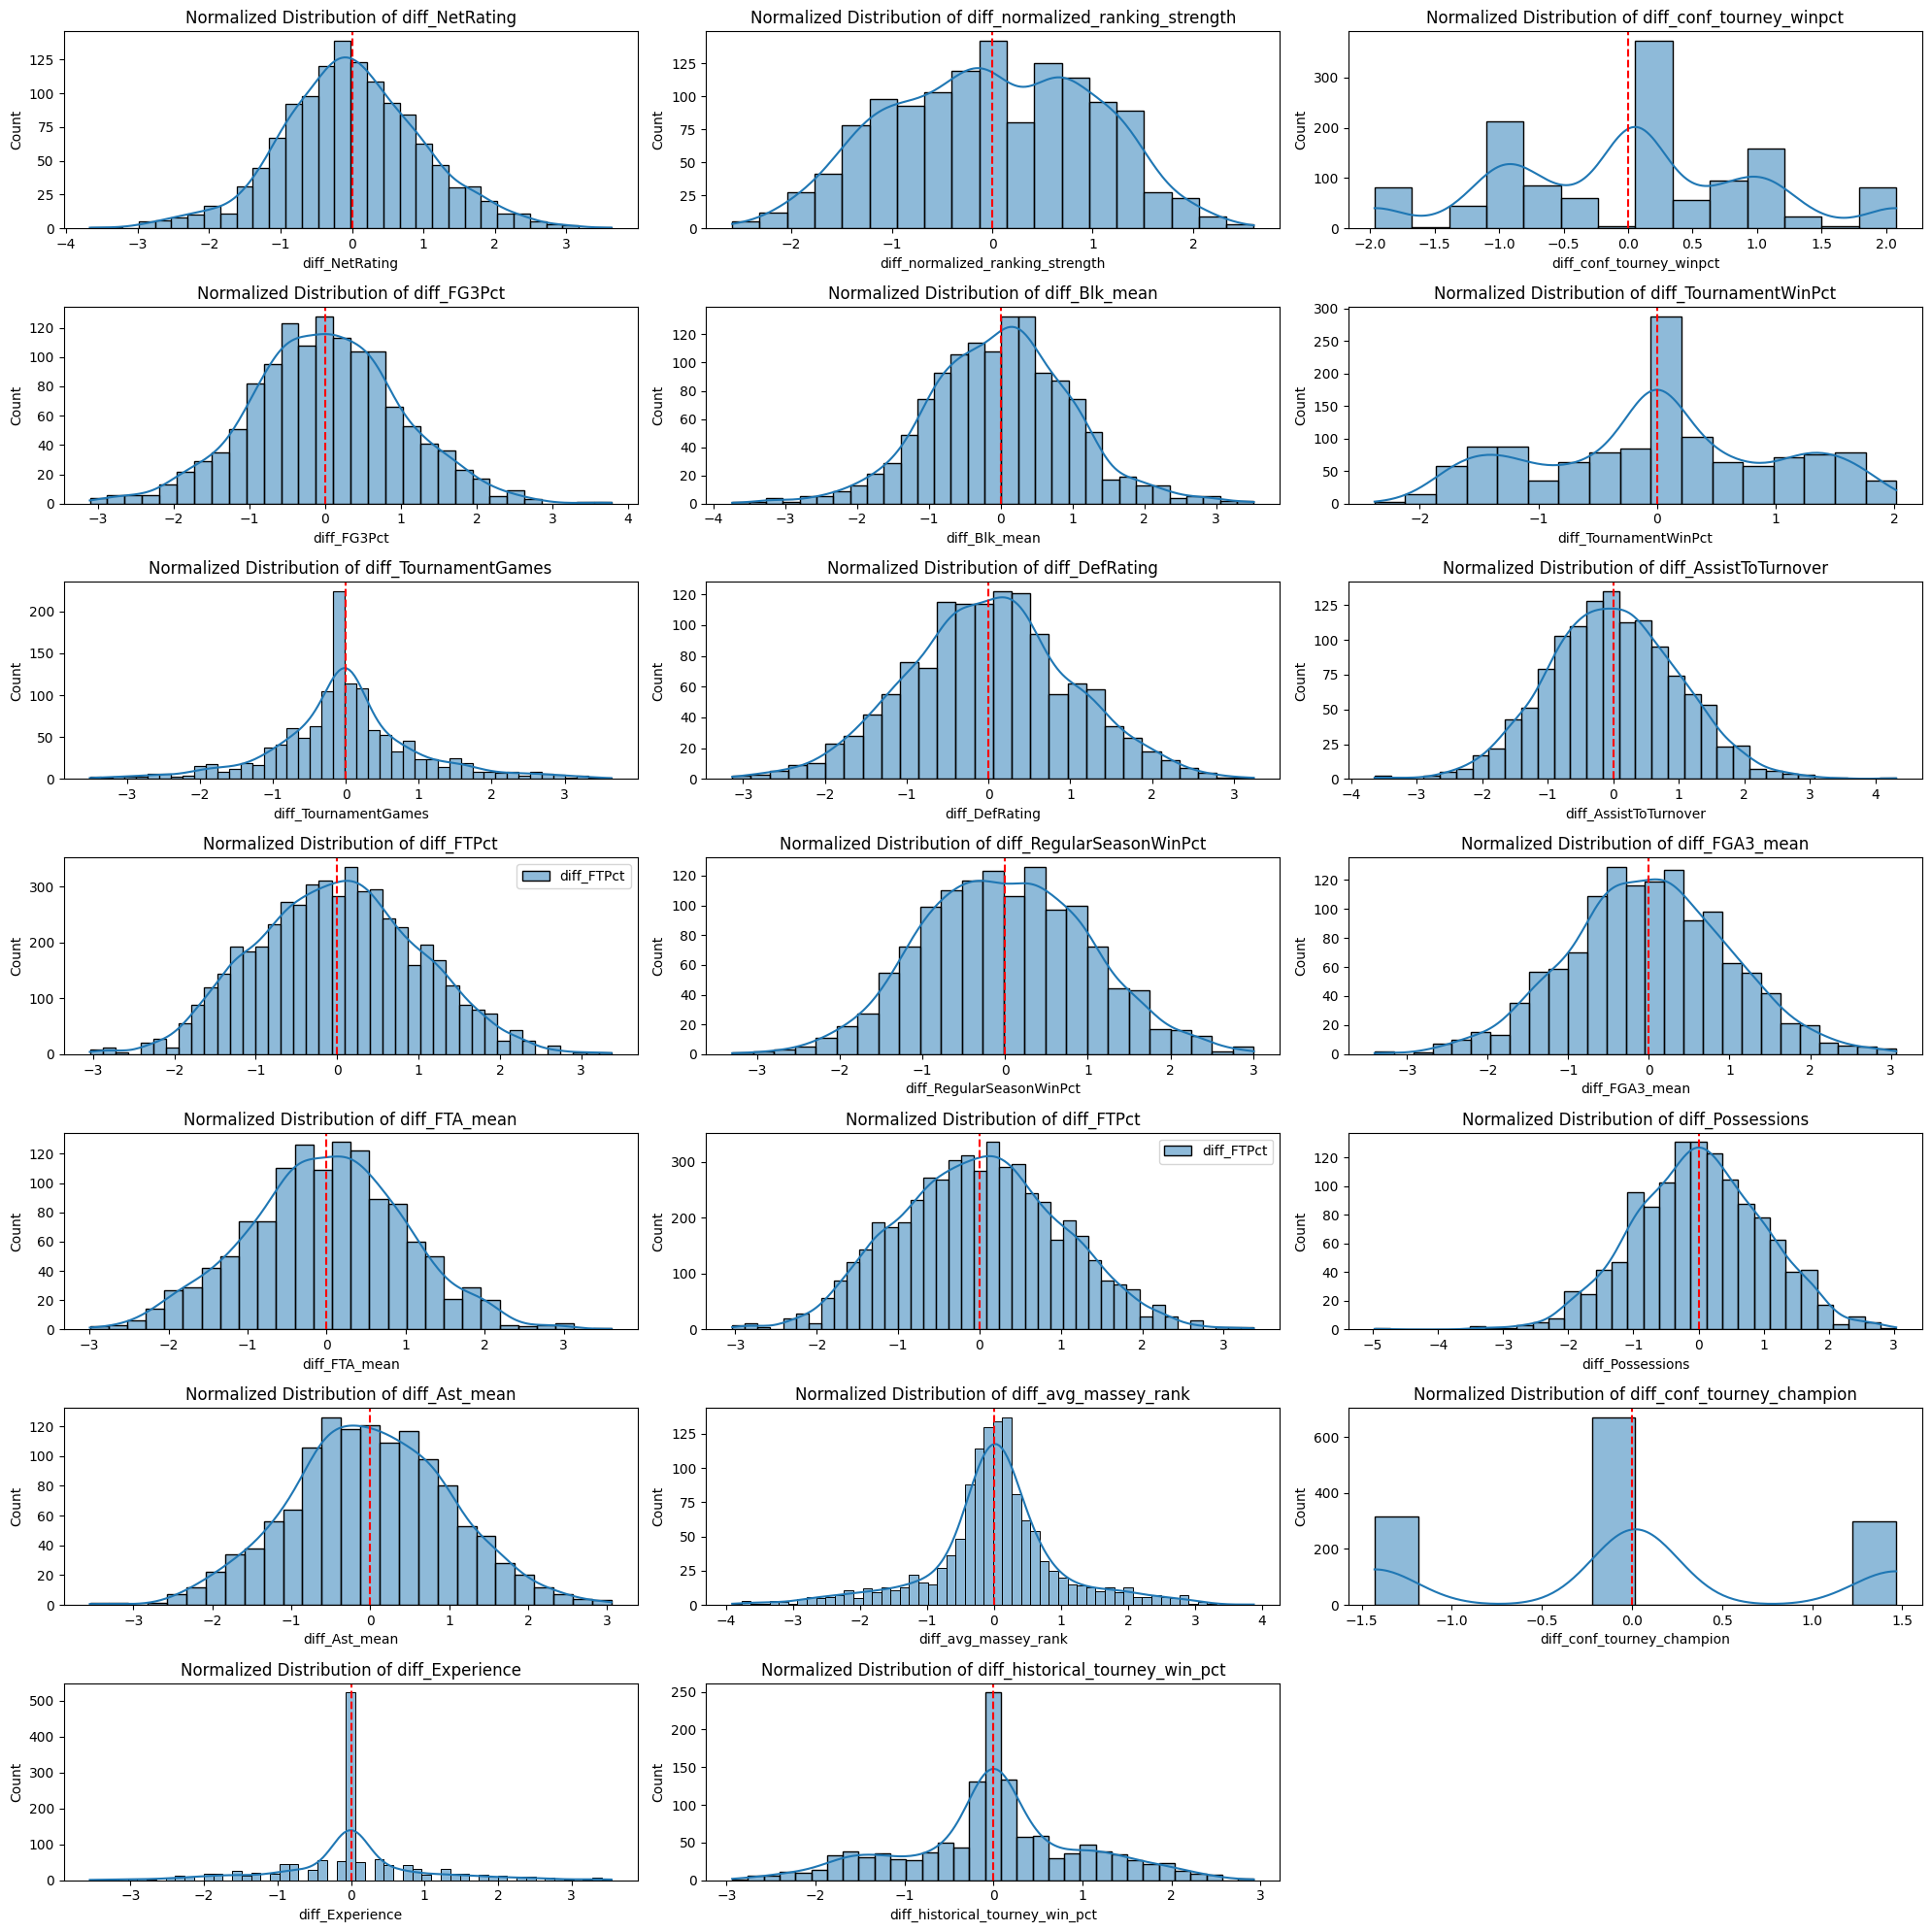

In [17]:
plt.figure(figsize=(20, 20))
for i, feature in enumerate(differential_features):
    plt.subplot(7, 3, i+1)
    sns.histplot(X_scaled[feature], kde=True)
    plt.title(f'Normalized Distribution of {feature}')
    plt.axvline(x=0, color='red', linestyle='--')
    plt.tight_layout()
plt.savefig('normalized_distributions.png')
# plt.close()

Performing recursive feature elimination with cross-validation across seasons...

Optimal number of features: 12
Best cross-validation score: 0.7565

Selected features:
- diff_NetRating
- diff_normalized_ranking_strength
- diff_Blk_mean
- diff_TournamentWinPct
- diff_TournamentGames
- diff_AssistToTurnover
- diff_FTPct
- diff_RegularSeasonWinPct
- diff_Ast_mean
- diff_avg_massey_rank
- diff_conf_tourney_champion


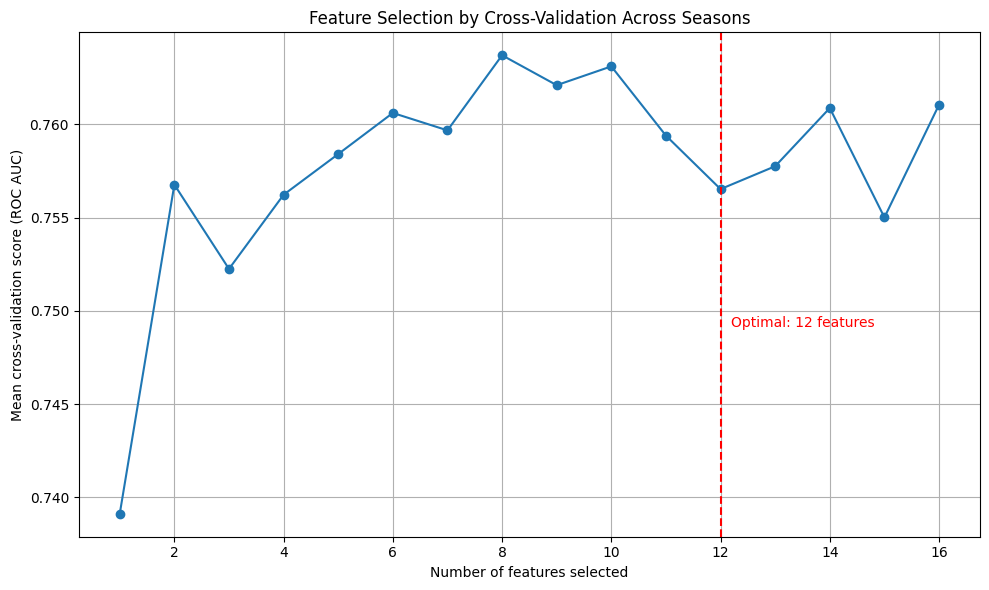

Length of importances array: 12
Length of selected features: 11
Length mismatch between importances and features. Training new model for visualization...


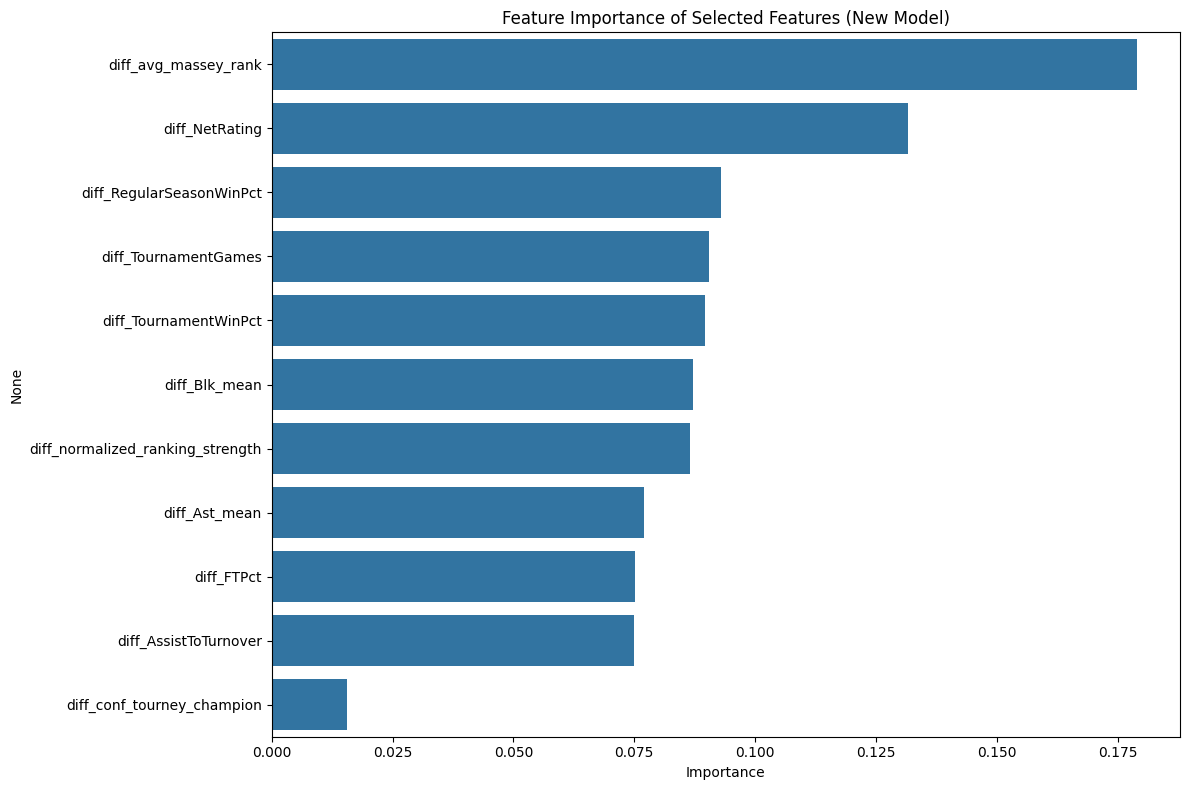


CV Results by Season:
--------------------------------------------------
Season    AUC Score      Selected Features
--------------------------------------------------
2006      0.7193
2007      0.8674
2008      0.8239
2009      0.7784
2010      0.7689
2011      0.6250
2012      0.7495
2013      0.6805
2014      0.7805
2015      0.7879
2016      0.7914
2017      0.7509
2018      0.7554
2019      0.7733
2021      0.7599
2022      0.7300


In [27]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

X = df_meta_clean[differential_features]
y = df_meta_clean['TeamA_Won']
seasons = df_meta_clean['Season']

# Step 2: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Create time-based cross-validation splits
# We'll create a time-based split where each fold trains on all seasons before a given season
# and tests on that season
def create_time_cv_splits(seasons, min_train_seasons=3):
    """
    Create time-based CV splits where each fold trains on all seasons 
    before a given season and tests on that season.
    Returns a PredefinedSplit object.
    """
    unique_seasons = sorted(seasons.unique())
    
    # Create test fold indicators
    test_fold = np.ones(len(seasons), dtype=int) * -1  # Default: not in any test fold
    
    fold_idx = 0
    for i, season in enumerate(unique_seasons):
        # Skip early seasons to ensure we have enough training data
        if i < min_train_seasons:
            continue
            
        # Set test fold for current season
        test_fold[seasons == season] = fold_idx
        fold_idx += 1
    
    # Return PredefinedSplit object
    return PredefinedSplit(test_fold)

# Create time-based CV
time_cv = create_time_cv_splits(seasons, min_train_seasons=3)

# Step 4: Create a base estimator
estimator = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 5: Set up RFECV (RFE with cross-validation)
rfecv = RFECV(
    estimator=estimator,
    step=1,                  # Remove one feature at a time
    cv=time_cv,              # Time-based cross-validation
    scoring='roc_auc',       # Use AUC as scoring
    min_features_to_select=5, # Minimum number of features to keep
    n_jobs=-1                # Use all available CPU cores
)

# Step 6: Fit RFECV
print("Performing recursive feature elimination with cross-validation across seasons...")
rfecv.fit(X_scaled, y)

# Step 7: Display results
print(f"\nOptimal number of features: {rfecv.n_features_}")

# Fix for the IndexError - safely access the mean_test_score
best_idx = min(rfecv.n_features_ - 1, len(rfecv.cv_results_['mean_test_score']) - 1)
print(f"Best cross-validation score: {rfecv.cv_results_['mean_test_score'][best_idx]:.4f}")

# Step 8: Get selected features
selected_features = [X_columns[i] for i in range(len(X_columns)) if rfecv.support_[i]]
print("\nSelected features:")
for feature in selected_features:
    print(f"- {feature}")

# Step 9: Visualize number of features vs. cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel("Number of features selected")
plt.ylabel("Mean cross-validation score (ROC AUC)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), 
         rfecv.cv_results_['mean_test_score'], 'o-')
plt.title('Feature Selection by Cross-Validation Across Seasons')
plt.grid(True)

# Add a vertical line at the optimal number of features
plt.axvline(x=rfecv.n_features_, color='r', linestyle='--')
plt.text(rfecv.n_features_ + 0.2, min(rfecv.cv_results_['mean_test_score']) + 0.01,
         f'Optimal: {rfecv.n_features_} features', color='r')

plt.tight_layout()
plt.show()

# Step 10: Feature importance ranking for selected features
if hasattr(rfecv.estimator_, 'feature_importances_'):
    # Get the final estimator's feature importances
    importances = rfecv.estimator_.feature_importances_
    
    # Verify the lengths match
    print(f"Length of importances array: {len(importances)}")
    print(f"Length of selected features: {len(selected_features)}")
    
    # Create feature importance visualization only if lengths match
    if len(importances) == len(selected_features):
        feature_importance = pd.Series(
            importances,
            index=selected_features
        ).sort_values(ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_importance.values, y=feature_importance.index)
        plt.title('Feature Importance of Selected Features')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
    else:
        # Alternative approach: train a new model on just the selected features
        print("Length mismatch between importances and features. Training new model for visualization...")
        
        # Extract the selected features directly from the already scaled data
        selected_indices = [list(X.columns).index(feature) for feature in selected_features]
        X_selected_scaled = X_scaled[:, selected_indices]
        
        # Train a new Random Forest on just the selected features
        rf_viz = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_viz.fit(X_selected_scaled, y)
        
        # Get feature importances from this new model
        feature_importance = pd.Series(
            rf_viz.feature_importances_,
            index=selected_features
        ).sort_values(ascending=False)
        
        # Plot the feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x=feature_importance.values, y=feature_importance.index)
        plt.title('Feature Importance of Selected Features (New Model)')
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
else:
    print("Feature importance not available for this estimator")

# Step 11: Print CV Results by Season
unique_seasons = sorted(seasons.unique())[3:]  # Skip the first 3 seasons used only for training
test_fold_indices = np.unique(time_cv.test_fold[time_cv.test_fold >= 0])

print("\nCV Results by Season:")
print("-" * 50)
print(f"{'Season':<10}{'AUC Score':<15}{'Selected Features':<10}")
print("-" * 50)

for i, season in zip(test_fold_indices, unique_seasons):
    if i < len(rfecv.cv_results_['split' + str(i) + '_test_score']):
        season_score = rfecv.cv_results_['split' + str(i) + '_test_score'][best_idx]
        print(f"{season:<10}{season_score:.4f}")